# Time Series Analysis: Sales Data Forecasting
---

In this project, we will use a dataset that contains sales data from a store to forecast future sales. The dataset includes information such as the date and the number of sales on that date.

First, let's create a synthetic sales dataset using Python's pandas library. We'll create data for 3 years on a daily basis.

In [23]:
import pandas as pd
import numpy as np

# Date range from Jan 1, 2020 to Dec 31, 2022
date_range = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')

np.random.seed(0)

# Create a pandas dataframe with date as index and sales as a synthetic random value
# Add a trend component and a yearly seasonality component
sales_df = pd.DataFrame({
    'date': date_range,
    'sales': np.linspace(100, 500, num=len(date_range)) + # Trend component
             50 * np.sin(2 * np.pi * np.arange(len(date_range)) / 365) + # Seasonality component
             np.random.normal(scale=20.0, size=len(date_range)) # Noise component
}).set_index('date')

sales_df.to_csv('./data/sales_data.csv')

In [24]:

import os
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from IPython.display import Image
from pdf2image import convert_from_path

# Get the absolute path to the sales_data.csv file
current_dir = os.getcwd()
sales_data_path = os.path.join(current_dir, 'data', 'sales_data.csv')
sales_figure_path = os.path.join(current_dir, 'figures', 'sales_data_forecast.png')

# Set the CRAN mirror
robjects.r('''
options(repos = c(CRAN = "https://cloud.r-project.org"))
''')

# Install the necessary packages if not already installed
required_packages = StrVector(['forecast', 'tseries', 'ggplot2'])
if any(x not in robjects.r('installed.packages()') for x in required_packages):
    utils = importr('utils')
    utils.install_packages(required_packages)

# Load necessary libraries
forecast = importr('forecast')
tseries = importr('tseries')
graphics = importr('graphics')
ggplot2 = importr('ggplot2')

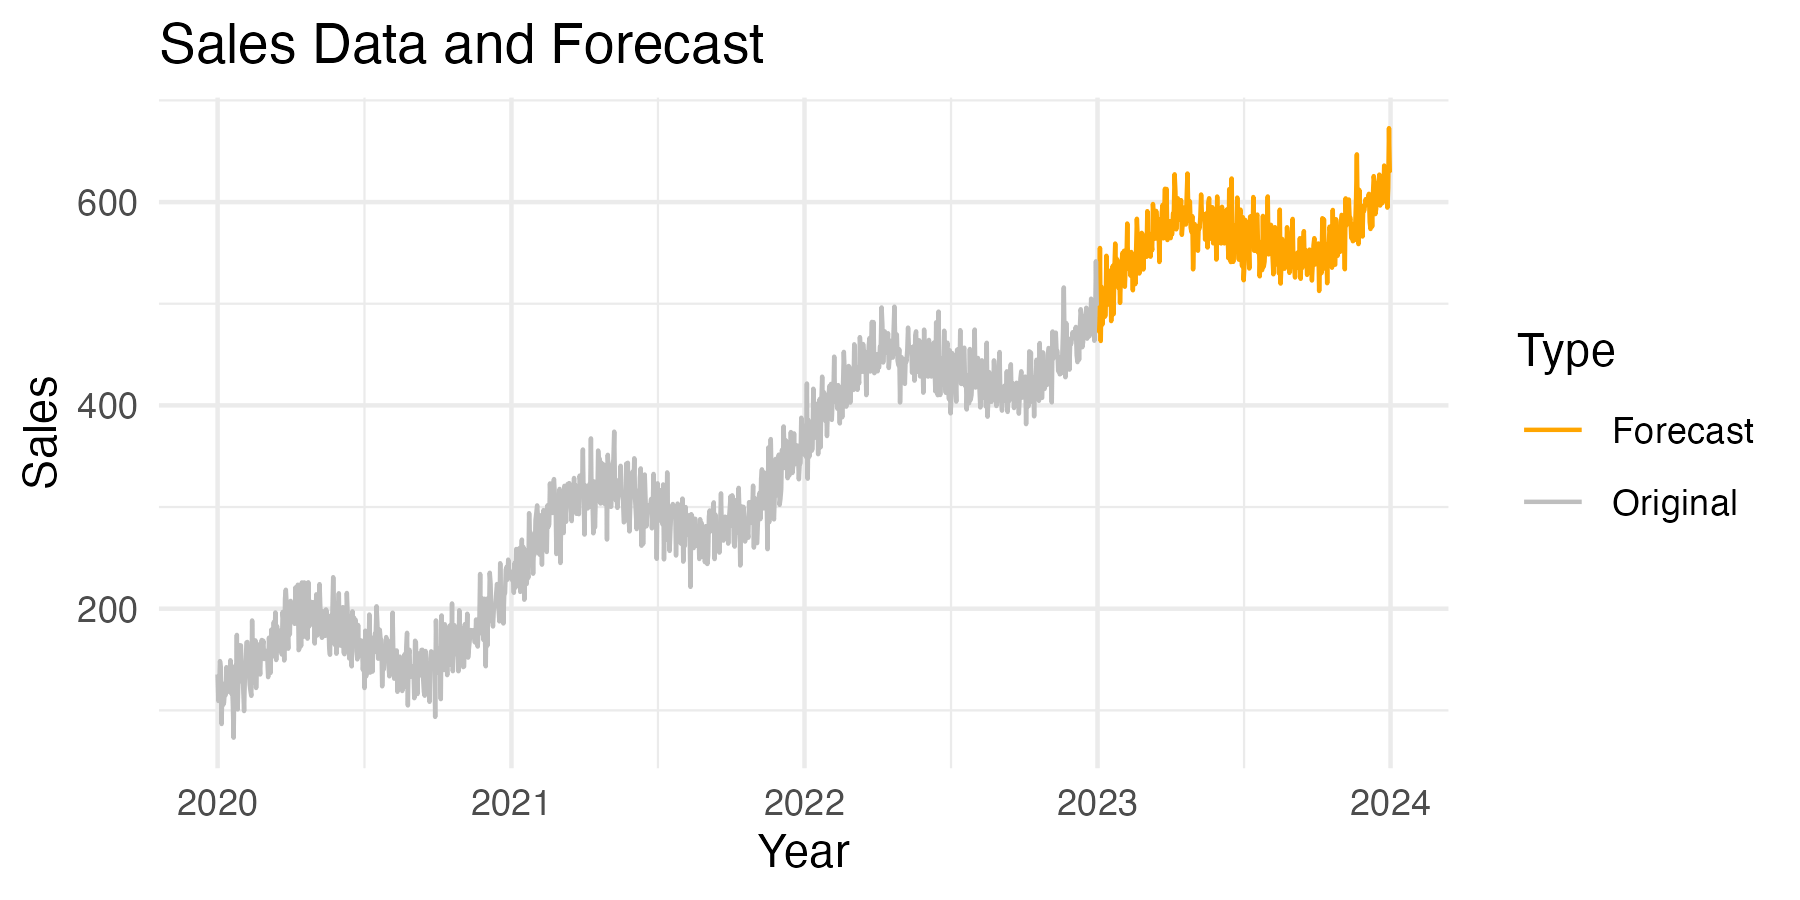

In [25]:
# Load the data into R
r_script = f'''
library(ggplot2)
library(zoo)

sales_data <- read.csv("{sales_data_path}")


# Convert the data to a time series object
sales_data$date <- as.Date(sales_data$date)
#sales_data$month <- format(sales_data$date, "%Y-%m-%d")
#monthly_sales <- aggregate(sales ~ month, data = sales_data, FUN = sum)
sales_data_ts <- ts(sales_data$sale, start = c(2020, 1, 1), frequency = 365)

# Fit an auto.arima model to the original data
fit <- auto.arima(sales_data_ts)

# Forecast the next year of sales
future_sales <- forecast(fit, h = 365)

# Create a data frame for the forecast data
forecast_start_date <- as.Date("2023-01-01") # This should be the day after your last known sales date
forecast_dates <- seq.Date(forecast_start_date, by = "day", length.out = length(future_sales$mean))

forecast_data <- data.frame(Date = forecast_dates, Sales = as.vector(future_sales$mean))

# Combine original and forecast data
combined_data <- rbind(data.frame(Date = as.Date(sales_data$date), Sales = sales_data$sales, Type = 'Original'), data.frame(Date = forecast_data$Date, Sales = forecast_data$Sales, Type = 'Forecast'))

# Plot original and forecast data
ggplot(data = combined_data, aes(x = Date, y = Sales, color = Type)) + 
  geom_line() +
  scale_color_manual(values = c('Original' = 'gray', 'Forecast' = 'orange')) +
  labs(x = "Year", y = "Sales", title = "Sales Data and Forecast", color = "Type") +
  theme_minimal()
ggsave("{sales_figure_path}", width = 6, height = 3)
'''

# Execute the R script
robjects.r(r_script)

# Display the image
Image(filename=sales_figure_path)


Now that we have the data, we will use R and the `forecast` package for time series forecasting.

This script loads the sales data, fits an ARIMA model to it, and then forecasts the next year's sales. 

That's the whole data science workflow for this project! You may need to install the necessary R packages if you don't have them yet. You can install them in R with `install.packages(c('forecast', 'tseries'))`. Also, remember that time series analysis can be a complex topic, and this is a very basic example. There are many other factors you may need to consider in a real-world situation, such as trend and seasonality adjustments, checking for stationarity, etc.